In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy.signal import remez, freqz
from sklearn.preprocessing import StandardScaler
import librosa
import tensorflow as tf

import glob
import mne
import re
import random
import copy
import pickle
import os
from tqdm import tqdm

import seaborn as sns
from matplotlib import pyplot as plt
sns.set()

import multiprocessing
from functools import partial

2022-08-22 14:49:56.553581: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-22 14:49:56.553605: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Set seeds
SEED=10
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# 1. Get filepaths

In [3]:
f = glob.glob('./physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/*.edf')
f.sort()

# 2. Get Filter coefficients for spectral decomposition

In [4]:
def get_spectral_decomposition_filters(
    waves_spectral_limits,
    transient_tolerance,
    waves_filter_orders,
    Fs
):
    
    # Get FIR coefficients for selecting each brain wave spectrum range
    waves_coeffs = {'original': [1]}
    for wave_name, wave_spectral_limits in waves_spectral_limits.items():
        # Lowpass filter for delta wave
        if wave_name=='delta':
            # Define LP specs
            filter_bands = [
                0,
                wave_spectral_limits['high'],
                wave_spectral_limits['high']*transient_tolerance['high'],
                Fs/2
            ]
            
            desired_response = [
                1,
                0
            ]
        else:
            # Define filter bands for Remez algorithm
            filter_bands = [
                0,
                transient_tolerance['low']*wave_spectral_limits['low'],
                wave_spectral_limits['low'],
                wave_spectral_limits['high'],
                wave_spectral_limits['high']*transient_tolerance['high'],
                Fs/2
            ]
            
            # Desired response of bandpass filter transfer fn
            desired_response = [
                0,
                1,
                0
            ]
        
        # Get FIR bandpass coeffs from remez algorithm
        coeffs = remez(
            numtaps=waves_filter_orders[wave_name],
            bands=filter_bands,
            desired=desired_response,
            fs=Fs
        )
        
        # Save coefficients
        waves_coeffs.update({wave_name: coeffs})
    
    return waves_coeffs
        

In [5]:
# Filter order plus one
ORDER = 100

# Sampling frequency
Fs = 100

# Spectral ranges for specific brain waves
waves_spectral_limits = {
    'delta': {
        'low': 0.5,
        'high': 4
    },
    'theta': {
        'low': 4,
        'high': 8
    },
    'alpha': {
        'low': 8,
        'high': 15
    },
    'spindle': {
        'low': 12.5,
        'high': 13.5
    },
    'beta1': {
        'low': 15,
        'high': 22
    },
    'beta2': {
        'low': 22,
        'high': 31
    },
    'gamma': {
        'low': 31,
        'high': 45
    },
}

# Filter orders for specific brain waves
waves_filter_orders = {
    'delta': 320,
    'theta': 320,
    'spindle': 320,
    'alpha': 192,
    'beta1': 144,
    'beta2': 144,
    'gamma': 144,
}

# Tolerance for transition bands between stopbands and passband
trans_tolerance = {
    'low': 0.95,
    'high': 1.05
}

waves_coeffs = get_spectral_decomposition_filters(
    waves_spectral_limits=waves_spectral_limits,
    transient_tolerance=trans_tolerance,
    waves_filter_orders=waves_filter_orders,
    Fs=Fs
)

In [6]:
def plot_filter_responses(
    waves_coeffs,
    Fs,
    n_frequency_points=512
):
    
    # Get number of waves
    n_waves = len(waves_coeffs.keys())
    
    # Initialize figure with one subplot per wave band
    fig, axs = plt.subplots(
        nrows=n_waves,
        ncols=1,
        figsize=(20,8*n_waves)
    )
    
    # Plot each filter's spectral response
    iterator = zip(
        list(waves_coeffs.keys()),
        axs
    )
    for wave, ax in iterator:
        # Get filter coefficients
        wave_coeffs = waves_coeffs[wave]
        
        # Get frequency response
        W, H = freqz(
            b=wave_coeffs,
            a=[1],
            worN=n_frequency_points
        )
        
        ###########################
        # Plot frequency response #
        ###########################
        
        # X axis frequencies in Hz
        plot_x = [0.5*Fs*w/np.pi for w in W]
        
        # Y axis magnitude response in dB
        plot_y = [20*np.log10(np.abs(h)) for h in H]
        
        # Create plot
        ax.plot(
            plot_x,
            plot_y
        )
        ax.set_title('Filter - {} wave'.format(wave))
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Magnitude response (dB)')

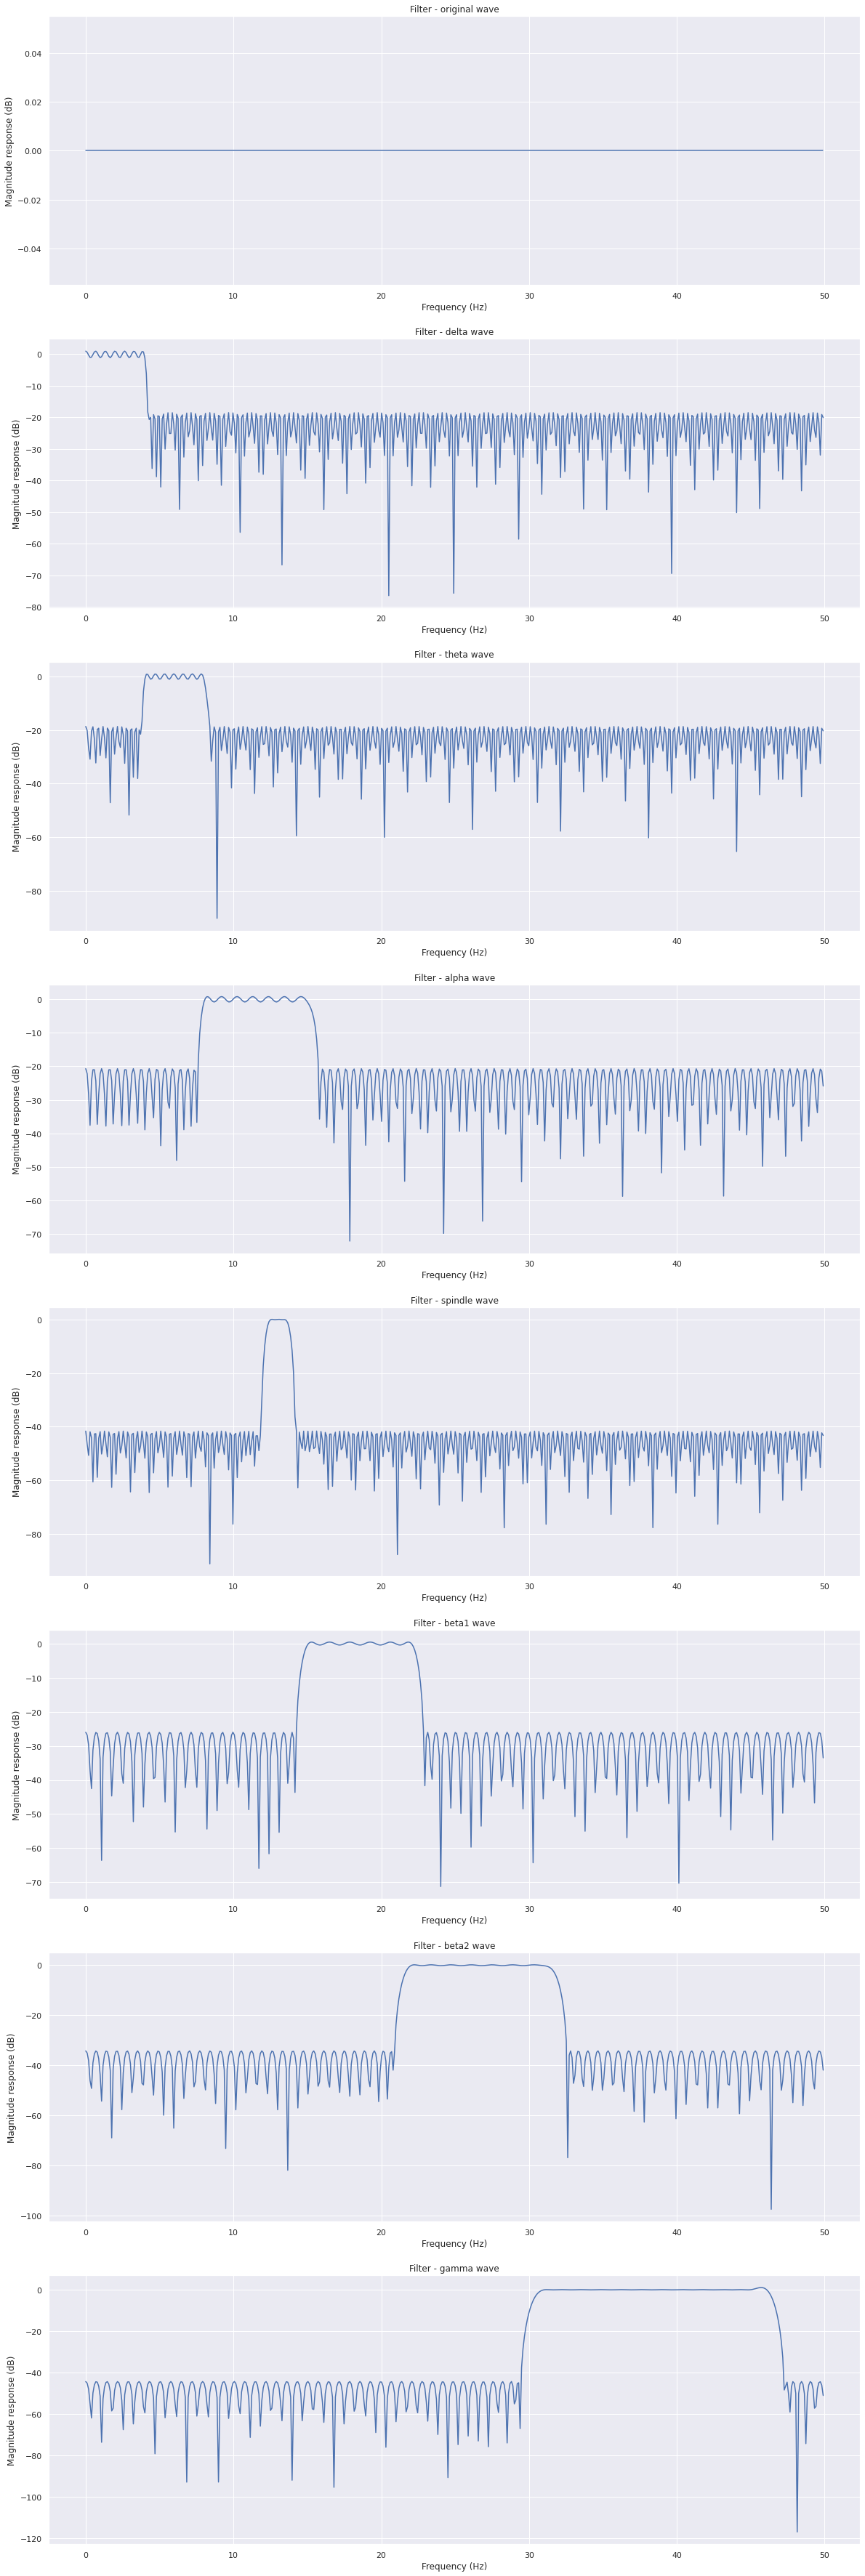

In [7]:
plot_filter_responses(
    waves_coeffs=waves_coeffs,
    Fs=Fs
)

In [8]:
def plot_filtered_sample(
    sample_sig,
    sample_label,
    waves_coeffs,
    Fs
):
    
    # Get number of waves
    n_waves = len(waves_coeffs.keys())
    
    # Initialize figure with one subplot per wave band
    fig, axs = plt.subplots(
        nrows=n_waves,
        ncols=1,
        figsize=(20,8*n_waves)
    )
    
    # Plot each filter's spectral response
    iterator = zip(
        list(waves_coeffs.keys()),
        axs
    )
    for wave, ax in iterator:
        # Get filter coefficients
        wave_coeffs = waves_coeffs[wave]
        
        # Get filtered signal
        filtered = sp.signal.lfilter(
            b=wave_coeffs,
            a=[1],
            x=sample_sig
        )
        
        ###########################
        # Plot frequency response #
        ###########################
        
        # X axis frequencies in Hz
        plot_x = [i/Fs for i in range(len(filtered))]
        
        # Y axis magnitude response in dB
        plot_y = filtered
        
        # Create plot
        ax.plot(
            plot_x,
            plot_y
        )
        ax.set_title('{} wave'.format(wave))
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Signal')

In [9]:
# Read PSG file
psg_data = mne.io.read_raw_edf(
    input_fname='./physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4001E0-PSG.edf',
    stim_channel='Event marker',
    misc=['Temp rectal']
)

# Read annotations for PSG file
psg_annot = mne.read_annotations('./physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4001EC-Hypnogram.edf')

# Set annotations for PSG file from read annotations file
psg_data.set_annotations(psg_annot, emit_warning=False)

Extracting EDF parameters from /home/leonardo/git/eeg-sleep-stage-detection/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<RawEDF | SC4001E0-PSG.edf, 7 x 7950000 (79500.0 s), ~12 kB, data not loaded>

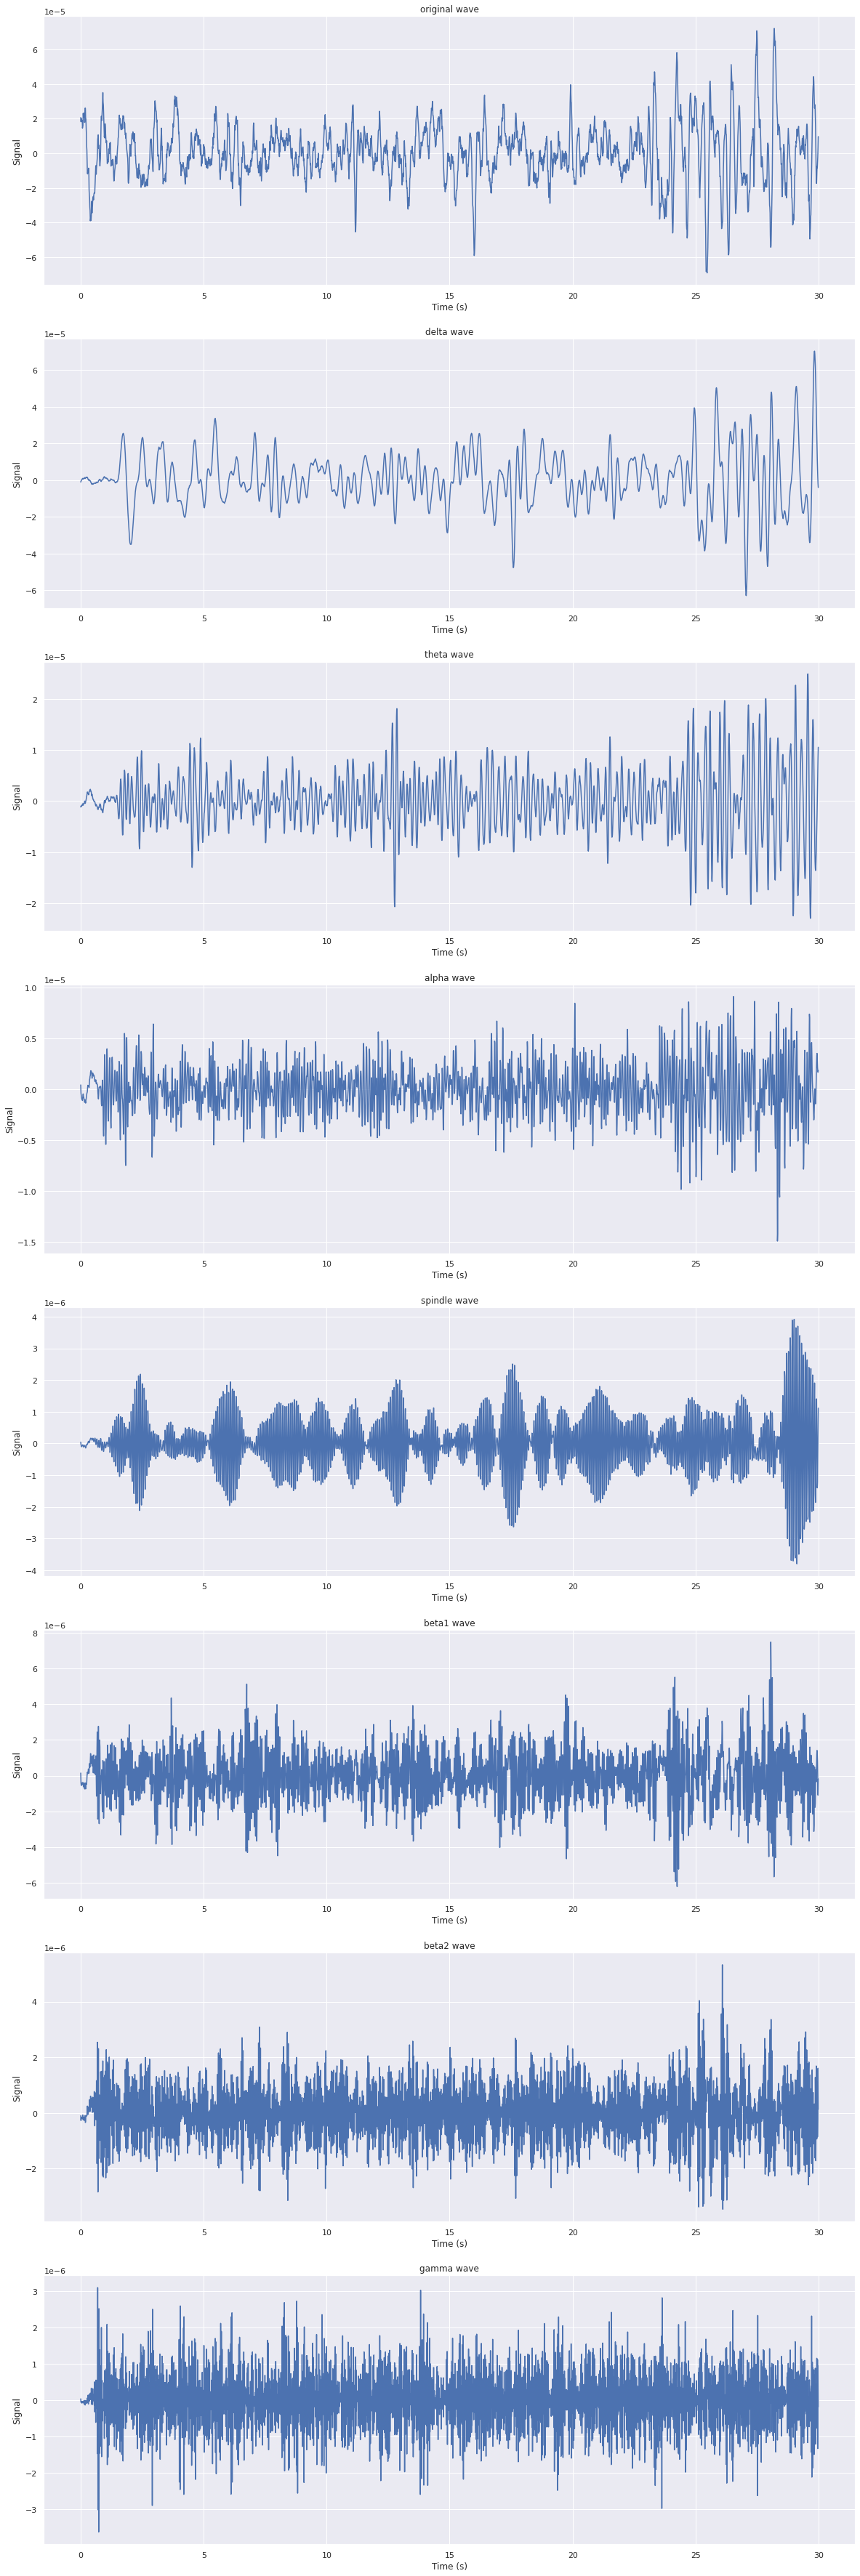

In [10]:
# Get sample signal, behavior onsets and labels
eeg_fpz_cz_sig = psg_data['EEG Fpz-Cz'][0][0]
onsets = psg_annot.onset
labels = psg_annot.description

# Get windowing indexes and label
used_segment=2
wdw_size = 3000
wdw_start = int(Fs*onsets[used_segment])
wdw_end = int(wdw_start + wdw_size)
sample_label=labels[used_segment]

# Plot filtered waves
plot_filtered_sample(
    sample_sig=eeg_fpz_cz_sig[wdw_start:wdw_end],
    sample_label=sample_label,
    waves_coeffs=waves_coeffs,
    Fs=Fs
)

# 3. Create Features

In [11]:
def get_label_distribution(proc):
    all_labels = []
    for subj, subj_samples in proc.items():
        all_labels.extend(subj_samples[:,-1])
        
    print('-'*100)
    print('Total samples generated: {}'.format(len(all_labels)))
    print('Labels distribution: \n{}'.format(pd.Series(all_labels).value_counts()))
    print('-'*100)
            

def map_subjects_files(filepaths):
    # Get identifier for subject+night for each file
    subj_night = list(
        set([re.search('SC4[0-9]{3}', x).group(0) for x in filepaths])
    )
    subj_night.sort()

    # Initialize dict with subjects as keys. Values will be array of arrays.
    subj_files = {s[3:5]: [] for s in subj_night}

    # Iterate through nights to group data+label files for each night
    for sn in subj_night:
        # Get subject
        subj = sn[3:5]
        # Get pair of data+label files corresponding to subject-night
        sn_pair = [f for f in filepaths if sn in f]
        # Update dict values
        subj_files[subj].append(sn_pair)
    
    return subj_files


def katz_fractal_dimension(signal):
    
    # Get length of signal
    N = len(signal)
    
    # Define lambda function for euclidean distance
    euclidean_distance = lambda x1, x2: np.linalg.norm(np.subtract(x1, x2))
    
    # Get (x,y) coordinates for wave points and iterator that contains successive (x,y) pairs
    coordinates = [
        [i, x] for i, x in zip(range(len(signal)), signal)
    ]
    iterator = zip(
        coordinates[:-1],
        coordinates[1:]
    )
    
    # Get sum of distances between successive points
    L = np.sum([
        euclidean_distance(
            x1=x1,
            x2=x2
        ) for x1, x2 in iterator
    ])
    
    # Get maximum distance between first point and any other point, consider only points halfway on for 
    # less computational complexity
    x0 = coordinates[0]
    halfway = N//2
    d = np.max(
        [euclidean_distance(x1=x0, x2=x) for x in coordinates[halfway:]]
    )
    
    # Get katz fractal dimension
    katz_fd = np.log10(N)/(np.log10(N*d/L))
    
    return katz_fd


def petrosian_fractal_dimension(signal):
    
    # Get length of signal
    N = len(signal)
    
    # Differentiate signal
    signal_diff = np.diff(signal)
    
    # Get adjacent diffs in pairs for analysis
    adj_diffs = zip(
        signal_diff[:-1],
        signal_diff[1:]
    )
    
    # Get number of sign changes
    M = np.sum([
       1 for x1, x2 in adj_diffs if np.sign(x1) != np.sign(x2)
    ])
    
    # Get Petrosian fractal dimension
    petrosian_fd = np.log10(N)/np.log10(np.square(N)/(N+0.4*M))
    
    return petrosian_fd


def higuchi_fractal_dimension(signal):
    
    # Get length of signal
    N = len(signal)
    
    # Get range of k's which will be evaluated
    eval_ks = range(1, 7)
    
    L_k = []
    # Iterate over k's
    for k in eval_ks:
        L_m_k = []
        # Iterate over starting points
        for m in range(1, k+1):
            # Get indices which will be evaluated in summation
            eval_idxs = range(1, int((N-m)/k))
            
            # Get sum of distances between k-separated points
            length_m_k = np.sum([
                np.abs(signal[m + i*k] - signal[m + (i-1)*k]) for i in eval_idxs
            ])
            
            # Normalize to obtain L_m(k)
            length_m_k *= (N-1)/(np.square(k)*(N-m)/k)
            
            # Append to L_m_k
            L_m_k.append(length_m_k)
        
        # Append average over m's to L(k)
        L_k.append(
            np.mean(L_m_k)
        )
        
    # Get slope of best-fitting linear function through log(1/k);log(L/k)
    higuchi_fd = np.polyfit(
        x=[np.log10(1/k) for k in eval_ks],
        y=np.log10(L_k),
        deg=1
    )[0]
    
    return higuchi_fd

def hjorth_mobility(signal):
    return np.std(np.diff(signal))/np.std(signal)
    
def hjorth_complexity(signal):
    return hjorth_mobility(np.diff(signal))/hjorth_mobility(signal)
            

def get_window_features(
    wave,
    filtered_signal,
    scaler
):
    
    # Scale signal
    scaled_signal = scaler().fit_transform(
        filtered_signal.reshape(-1, 1)
    ).reshape(
        (len(filtered_signal),)
    )
    
    # Get features from scaled signal, according to feature selection performed
    filtered_features = {
        '{}_kurtosis'.format(wave): sp.stats.kurtosis(scaled_signal),
        '{}_katz_fd'.format(wave): katz_fractal_dimension(scaled_signal),
        '{}_petrosian_fd'.format(wave): petrosian_fractal_dimension(scaled_signal),
        '{}_higuchi_fd'.format(wave): higuchi_fractal_dimension(scaled_signal),
        '{}_hjorth_mobility'.format(wave): hjorth_mobility(scaled_signal),
        '{}_hjorth_complexity'.format(wave): hjorth_complexity(scaled_signal),
        '{}_spectral_bandwidth_mean'.format(wave): librosa.feature.spectral_bandwidth(y=scaled_signal, sr=FS).mean(),
        '{}_spectral_roll_off_mean'.format(wave): librosa.feature.spectral_rolloff(y=scaled_signal, sr=FS, roll_percent=0.95).mean(),
        '{}_spectral_flatness_mean'.format(wave): librosa.feature.spectral_flatness(y=scaled_signal).mean()
    }
    
    # If original wave, return signal as well
    if wave=='original':
        filtered_features['eeg_segment'] = np.array(scaled_signal, dtype=np.float32)
        
    
    return filtered_features



def window_state_signal(
    label_sig,
    label,
    waves_coeffs,
    scaler
):
    
    # Get filtered signal for each spectrum range specification
    filtered_signals = {
        wave: sp.signal.lfilter(
            b=coeffs,
            a=[1],
            x=label_sig
        ) for wave, coeffs in waves_coeffs.items()
    }
    
    # Get number of samples which will be generated
    n_samples = len(label_sig)//WINDOW_SIZE
    
    # Get windows from original signal, according to spectrum identification
    samples = []
    for i in range(n_samples):        
        # Get features relative to sample, for each wave decomposition
        window_features = dict()
        for wave in waves_coeffs.keys():
            window_features.update(
                get_window_features(
                    wave=wave,
                    filtered_signal=filtered_signals[wave][WINDOW_SIZE*i: WINDOW_SIZE*(i+1)],
                    scaler=scaler
                )
            )
        
            
        # Get explicit feature names and sort to guarantee schema order
        explicit_features_names = [f for f in window_features.keys() if f != 'eeg_segment']
        explicit_features_names.sort()
        
        # Get explicit features
        explicit_features = np.array(
            [
                window_features[f] for f in explicit_features_names
            ],
            dtype=np.float32
        )
        
        # Get eeg segment
        eeg_segment = window_features['eeg_segment']
            
        # Get label 
        label_mapped = LABEL_MAP[label]
        
        samples.append(
            (
                (eeg_segment, explicit_features),
                label_mapped
            )
        )

    return np.array(samples, dtype=object)

def process_subj_night(
    subj_night_files,
    waves_coeffs,
    scaler
):
    
    # Get data and labels files
    psg_file = [f for f in subj_night_files if 'PSG' in f][0]
    annot_file = [f for f in subj_night_files if 'Hypnogram' in f][0]
    
    # Read PSG file
    psg_data = mne.io.read_raw_edf(
        psg_file,
        stim_channel='Event marker',
        misc=['Temp rectal'],
        verbose=False
    )
    
    # Read annotations file
    psg_annot = mne.read_annotations(annot_file)
    
    # Obtain Fpz-Cz signal from PSG
    psg_fpz_cz = psg_data['EEG Fpz-Cz'][0][0]
    
    # Get labels, label onsets and durations
    onsets = [int(100*o) for o in psg_annot.onset[:-1]]
    durations = [int(100*d) for d in psg_annot.duration[:-1]]
    labels = psg_annot.description[:-1]
    
    # Iterate through marked labels
    iterator = zip(
        range(len(onsets)),
        onsets,
        durations,
        labels
    )
    subj_night_samples = pd.DataFrame()
    for stage_i, onset, dur, label in iterator:
        # Exclude other labels
        if label not in LABEL_MAP.keys():
            if label not in ['Movement time', 'Sleep stage ?']:
                print('Excluded label: {}, Duration: {} seconds'.format(label, dur/100))
            continue

        # Window signal duration corresponding to label
        label_sig = psg_fpz_cz[onset:onset+dur]

        if len(label_sig) >= WINDOW_SIZE:
            # If long wake stages, keep last 30 minutes if first long wake period and first 30 minutes
            # if last long wake period
            if LABEL_MAP[label]=='W':
                if len(label_sig) >= 720000:
                    if stage_i < 5:
                        label_sig = label_sig[-180000:]
                    if stage_i >= len(onsets) - 5:
                        label_sig = label_sig[:180000]
            
            # Window signal to obtain samples if segment is longer than WINDOW_SIZE
            segment_samples = window_state_signal(
                label_sig=label_sig,
                label=label,
                waves_coeffs=waves_coeffs,
                scaler=scaler
            )
        elif len(label_sig) < WINDOW_SIZE:
            # Don't add if not enough samples
            continue
            
        # Append to subj_night_samples
        if subj_night_samples.size==0:
            subj_night_samples = segment_samples
        else:
            if segment_samples.size>0:
                subj_night_samples = np.concatenate(
                    (
                        subj_night_samples,
                        segment_samples
                    ),
                    axis=0
                )
    return subj_night_samples  


def process_subject(
    waves_coeffs,
    scaler,
    seed,
    subj_item  
):
    np.random.seed(seed)
    random.seed(seed)
    
    subj = subj_item[0]
    subj_files = subj_item[-1]
    
    subj_samples = np.array([])
    for f in subj_files:
        # Process one night of subject
        subj_night_samples = process_subj_night(
            subj_night_files=f,
            waves_coeffs=waves_coeffs,
            scaler=scaler
        )
        
        # Append to subj_samples
        if subj_samples.size==0:
            subj_samples = subj_night_samples
        else:
            subj_samples = np.concatenate(
                (
                    subj_samples,
                    subj_night_samples
                ),
                axis=0
            )
    return {subj: subj_samples}

def process_dataset(
    waves_coeffs,
    subj_files,
    scaler,
    seed
):
    
    # Fixate waves coeffs argument
    subj_exec_fn = partial(
        process_subject,
        waves_coeffs,
        scaler,
        seed
    )
    items = [it for it in subj_files.items()]
    # Distributed execution for each subject
    with multiprocessing.Pool(NJOBS) as p:
        results = p.map(
            subj_exec_fn,
            subj_files.items()
        )
    
    # Unify dataframes
    proc_samples = {}
    for subj_samples in results:
        proc_samples.update(subj_samples)
        
    return proc_samples


In [12]:
%%time
# General execution configurations
LABEL_MAP = {
    'Sleep stage W': 'W',
    'Sleep stage 1': 'N1',
    'Sleep stage 2': 'N2',
    'Sleep stage 3': 'N3',
    'Sleep stage 4': 'N3',
    'Sleep stage R': 'R'
}
WINDOW_SIZE = 3000
FS = 100
FILEPATHS_SPEC = './physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/*.edf'
NJOBS = 10

# Get files for each subject
subj_files = map_subjects_files(
    filepaths=glob.glob(FILEPATHS_SPEC)
)

# Process raw files, extracting windows and returning raw signals, features and labels
proc = process_dataset(
    waves_coeffs=waves_coeffs,
    subj_files=subj_files,
    scaler=StandardScaler,
    seed=SEED
)

# Get label distribution
get_label_distribution(proc=proc)

----------------------------------------------------------------------------------------------------
Total samples generated: 192017
Labels distribution: 
N2    69132
W     62489
R     25835
N1    21522
N3    13039
dtype: int64
----------------------------------------------------------------------------------------------------
CPU times: user 3.78 s, sys: 3.81 s, total: 7.59 s
Wall time: 4h 46min 6s


In [16]:
# Save proc, if so desired
SAVE_PROC=True
SAVE_PROC_DIR='./artifacts/dataset_write/'
if SAVE_PROC:
    # Create directory if it doesn't exist
    if not os.path.isdir(SAVE_PROC_DIR):
        os.mkdir(SAVE_PROC_DIR)
    # Write file
    with open(SAVE_PROC_DIR + 'processed_dataset_dict.pkl', 'wb') as f:
        pickle.dump(proc, f)
        

# 4. Save TFRecord Files

In [14]:
def write_dataset(proc):
    # Write one subject
    for subj, samples in tqdm(proc.items()):
        
        # Get scaler for explicit features
        explicit_feats = np.array([s[0][-1] for s in samples])
        subj_scaler = StandardScaler().fit(explicit_feats)
        
        # Save scaler
        with open(SAVE_SCALER_DIR + 'scaler_' + subj + '.pkl', 'wb') as f:
            pickle.dump(subj_scaler, f)
        
        # Write each sample for subject in file with subject name
        with tf.io.TFRecordWriter(SAVE_DATASET_DIR + subj + '.tfrecord') as file_writer:
            for s in samples:
                eeg_feats_scaled = subj_scaler.transform(
                    s[0][-1].reshape((1, -1))
                ).reshape((72,)) 
                
                record_bytes = tf.train.Example(
                    features=tf.train.Features(
                        feature={
                            'eeg_raw': tf.train.Feature(float_list=tf.train.FloatList(value=s[0][0])),
                            'eeg_feats': tf.train.Feature(float_list=tf.train.FloatList(value=eeg_feats_scaled)),
                            'label': tf.train.Feature(float_list=tf.train.FloatList(value=LABEL_MAP_ONE_HOT[s[-1]])),
                        }
                    )
                ).SerializeToString()
                file_writer.write(record_bytes)

In [15]:
SAVE_DATASET_DIR = './proc_dataset/'
SAVE_SCALER_DIR = './artifacts/dataset_write/'

# Create directories if they don't exist
if not os.path.isdir(SAVE_DATASET_DIR):
    os.mkdir(SAVE_DATASET_DIR)
if not os.path.isdir(SAVE_SCALER_DIR):
    os.mkdir(SAVE_SCALER_DIR)
    
# Mapping for saving labels in one-hot format
LABEL_MAP_ONE_HOT = {
    'W': tf.keras.utils.to_categorical(0, num_classes = 5),
    'N1': tf.keras.utils.to_categorical(1, num_classes = 5),
    'N2': tf.keras.utils.to_categorical(2, num_classes = 5),
    'N3': tf.keras.utils.to_categorical(3, num_classes = 5),
    'R': tf.keras.utils.to_categorical(4, num_classes = 5)
}

# Write dataset
write_dataset(proc=proc)

100%|██████████████████████████████████████████████████████████████████████████████| 78/78 [01:32<00:00,  1.18s/it]
